# Introduction to Object Detection with Python, OpenCV and YOLO
This notebook reviews the steps necessary to access a pretrained YOLO model and use it to detect objects both images and videos.

## Background Information

### OpenCV
Open source computer vision (OpenCV) has been around for over 20 years and is the go-to library for all things computer vision. It is written in C++ but has bindings for Python, as well as Java and MATLAB.

### Convolutional Neural Networks (CNNs)
CNNs are a type of deep neural networks that are most commonly used for computer vision. The design of CNNs have a biological background and are inspired by the visual cortex. Individual neurons respond to stimuli only in a restricted region of the visual field known as the Receptive Field. A collection of such fields overlap to cover the entire visual area. If you would like to learn more about CNNs, [this blog post](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/) does a great job of explaining them in basic terms.

### YOLOv3
YOLO stands for You Only Look Once, and it is a prevalent type of single-stage detection algorithm. Single-stage detection algorithms treat object detection as a regression problem; they take a given input image and simultaneously learn bounding boxes and corresponding class label probabilities in a single step.

Single-stage detectors are known to be less accurate than two-stage detectors, but they are _significanly_ faster, which makes them ideal for object detection in videos.

Specifically we will be using YOLOv3. If you would like to learn more about YOLOv3, you should read it's [tech report](https://arxiv.org/pdf/1804.02767.pdf). 

### COCO Dataset
The YOLO model that we will be using has been trained on the Common Objects in Context (COCO) dataset. The COCO dataset contains 80 classes, 80K training images and 40K validation images. [Look here](https://github.com/pjreddie/darknet/blob/master/data/coco.names) for a full list of objects that can be detected with a model trained on the COCO dataset.

In [1]:
# import the necessary packages
import os
import cv2
import time
import imutils
import argparse
import numpy as np
from matplotlib import pyplot as plt

We will start be declaring some constants and providing the path to folders containing the YOLO model and our test image.

`CONFIDENCE` specifies the minimum probability needed for the model to classify an object. Increasing the confidence parameter will filter out weaker detections.

`THRESHOLD` specifies the non-maximum supression threshold. This is a technique designed to prevent multiple bounding boxes around the same image. You can read more about non-maximum supression [here](https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c).

In [2]:
CONFIDENCE = 0.7 

THRESHOLD = 0.3

# specify folder that contains our YOLO model files
yolo = 'yolo-coco'

# specify the path to our test image
image = 'images/test.jpg'

# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join([yolo, "yolov3.weights"])
configPath = os.path.sep.join([yolo, "yolov3.cfg"])

Next we will load the COCO class labels that our YOLO model was trained on

In [3]:
labelsPath = os.path.sep.join([yolo, "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")
LABELS[:8]

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck']

Then we create an array of colors (RGB values) to represent each of the 80 possible class labels

In [4]:
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
    dtype="uint8")
COLORS[:5]

array([[102, 220, 225],
       [ 95, 179,  61],
       [234, 203,  92],
       [  3,  98, 243],
       [ 14, 149, 245]], dtype=uint8)

Next we will load our YOLO object detector that was trained on the COCO dataset.

In [5]:
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
net

<dnn_Net 0x1033effb0>

Then we will load our test image as a numpy array and specifiy its spatial dimensions

In [6]:
image = cv2.imread(image)
H, W = image.shape[:2]

Next we will get the output layer names from our YOLO model, build a blob object from our test image, and perform a forward pass of the YOLO object detector.

OpenCV's `blobFromImage()` function transforms our test image into a blob object by performing mean subtraction, normalization and channel swapping on our image. Put simply, this gets our image ready to pass through the `dnn`. For more informaton about blobs and the preprocessing steps needed for images, check out [this blog](https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/). 

After our image has been pre-processed, we pass it into the Deep Neural Network, which returns predictions in the form of bounding boxes, classification labels and their associated probabilities.

In [7]:
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and associated probabilities
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layer_outputs = net.forward(ln)
end = time.time()

# show timing information on YOLO
print("YOLO took {:.6f} seconds to run".format(end - start))

YOLO took 1.858501 seconds to run


`layerOutputs` contains our predictions in the form of a nested numpy array. We need to loop through this array in order to extract the prediction scores, decide if they exceed our `CONFIDENCE` threshold, and if they do, draw a bounding box around the object and label it with it's classification name and probability

In [8]:
def parse_layers(layer_outputs, H, W, boxes=[], confidences=[], classIDs=[]):
    
    # loop over each of the layer outputs
    for output in layer_outputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability) of
            # the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            # filter out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            if confidence > CONFIDENCE:
                # scale the bounding box coordinates back relative to the
                # size of the image, keeping in mind that YOLO actually
                # returns the center (x, y)-coordinates of the bounding
                # box followed by the boxes' width and height
                box = detection[0:4] * np.array([W, H, W, H])
                centerX, centerY, width, height = box.astype("int")

                # use the center (x, y)-coordinates to derive the top and
                # and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # update our list of bounding box coordinates, confidences,
                # and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)
    return boxes, confidences, classIDs

def label_frame(image, boxes, confidences, classIDs):
    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE, THRESHOLD)

    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            # extract the bounding box coordinates
            x, y = (boxes[i][0], boxes[i][1])
            w, h = (boxes[i][2], boxes[i][3])

            # draw a bounding box rectangle and label on the image
            color = [int(c) for c in COLORS[classIDs[i]]]
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                0.5, color, 2)
            
boxes, confidences, classIDs = parse_layers(layer_outputs, H, W)
label_frame(image, boxes, confidences, classIDs)

The final step is to display our test image with the bounding boxes and label probabilities. Special care needs to be taken to display opencv images in a jupyter notebook, but luckily matplotlib's `imshow()` function makes this simple.

One thing I would like to point out here is that we need to use opencv's `cvtColor()` function to sort our image's pixels by RGB, rather than the BGR default.  

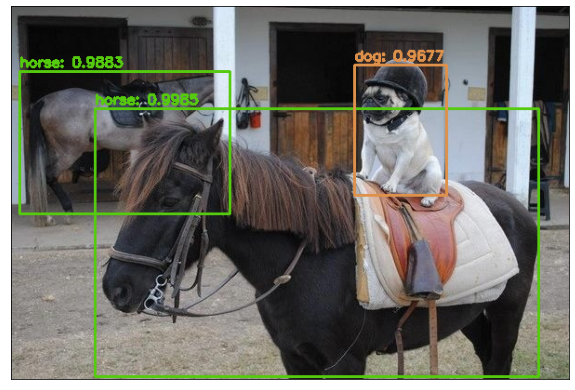

In [9]:
def show_image(image):
    # Sorts pixels by RGB, rather than BGR
    _, ax = plt.subplots(figsize=(10,14))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(image_rgb)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.show()

show_image(image)

## Object Detection with Video Streams
OpenCV also provides tools to use our YOLO model to detect images in video files! 

**Note:** I have included the code needed to detect objects from videos in this notebook for presentation purposes, but if you are trying run this on your own I _highly_ recommend that you use the `yolo_video.py` file instead. I found that running it as a .py file was much faster and more reliable than the notebook.

First we need to specify the path to our test video file, as well as the path to save the resulting video file, which will (hopefully) contain bounding boxes and prediction probabilities!

In [26]:
video = 'videos/car_chase_01.mp4'
outpath = 'output/cars.avi'

Next we initialize the video stream, as well as the video `writer`, which we will eventually initialize as a `cv2.VideoWriter()`, which is used to write our results to disk one frame at a time

In [27]:
# initialize the video stream, pointer to output video file, and frame dimensions
vs = cv2.VideoCapture(video)
writer = None
W, H = (None, None)

Then we will attempt to read the video stream object and determine how many frames there are in the video. Obviously the number of frames will affect how long the process of labeling the video takes.

In [28]:
# try to determine the total number of frames in the video file
try:
    prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() else cv2.CAP_PROP_FRAME_COUNT
    total = int(vs.get(prop))
    print("total frames in video: {}".format(total))

# an error occurred while trying to determine the total
# number of frames in the video file
except:
    print("Error: could not determine # of frames in video")
    print("Error: no approx. completion time can be provided")
    total = -1

total frames in video: 350


Now for the fun part - this giant loop reads and processes our video stream one frame at a time. A lot of this code should look familiar, as we are treating each frame as an image; we construct a blob from the input frame, perform a forward pass of the YOLO object detector, and write the resulting bounding boxes and probabilities to the image

In [30]:
# loop over frames from the video file stream
while True:
    # read the next frame from the file
    grabbed, frame = vs.read()

    # if the frame was not grabbed, then we have reached the end
    # of the stream
    if not grabbed:
        break

    # if the frame dimensions are empty, grab them
    if W is None or H is None:
        (H, W) = frame.shape[:2]

    # construct a blob from the input frame and then perform a forward
    # pass of the YOLO object detector, giving us our bounding boxes
    # and associated probabilities
    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
        swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    layer_outputs = net.forward(ln)
    end = time.time()

    boxes, confidences, classIDs = parse_layers(layer_outputs, H, W)
    
    label_frame(frame, boxes, confidences, classIDs)

    # initialize writer if it is None
    if writer is None:
        # initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        frame_width = int(vs.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height =int(vs.get( cv2.CAP_PROP_FRAME_HEIGHT))
    
        writer = cv2.VideoWriter(outpath, fourcc, 30, (frame_height, frame_width), True)

    # write the output frame to disk
    writer.write(frame)

writer.release()
vs.release()
print("All done!")

All done!


## Conclusion

### Limitatons of YOLO
While YOLO is incredibly useful due to the fact that is significanly faster than other available object detectors, such as R-CNNs, it is important to point out that is does have limitations; namely that it sometimes struggles to detect smaller objects, it sometimes is unable to draw a box perfectly around an object, and it struggles with identifying objects that are close together. If your use case requires detecting smaller objects and speed is not as much of a concern, you may be better of using an SSD or a Faster R-CNN 

### Alternatives
If you are looking for a network that provides more accuracy and speed is not as much of a concern, You may be better off with a two-stage detector such as [Faster-RCNN](https://arxiv.org/abs/1506.01497). Google [released a report](https://arxiv.org/pdf/1611.10012.pdf) that conducts a speed/accuracy comparison between various networks, and it found that Faster-RCNN was the most accurate - the only problem is it's speed.

[SSD](https://arxiv.org/abs/1512.02325) is another single-shot detector, similar to YOLO that is very popular. [Here](https://pytorch.org/hub/nvidia_deeplearningexamples_ssd/) is an example of how to use a SSD model that has been pre-trained on the COCO dataset to detect objects in images using PyTorch. Perhaps an interesting activity would be to attempt use this code to build an object detector for videos?!

### Potential Next Steps
**TODO: Briefly discuss transfer learning and provide resources to read more about it**

### Your turn!
Thanks to the contributions of those in the open source community, there are several tools available to help make object detection a remarkably manageable problem to solve with the help of pre-trained models. Try running this notebook or the attached python scripts with different test images/videos to see how it performs. You can also try playing with the `CONFIDENCE` and `THRESHOLD` parameters to see how this affects the objects that are detected.

Good luck!

## References

I cannot take credit for many of the ideas and code in this notebook. Below are some resources that were very helpful in putting this exercise together:

https://www.pyimagesearch.com/2018/11/12/yolo-object-detection-with-opencv/<br>
https://towardsdatascience.com/yolo-v3-object-detection-53fb7d3bfe6b<br>